# Binary Classifcation - Evens and Odds

We'll demonstrate a few things here.

* split the original MNIST training set into training and validation sets
* build a custom dataloader to return labels of 0 for even digits and 1 for odd digits
* make predictions and assess metrics on the test set
* our simple CNN will output a single number (a logit from the output layer)
* we'll use BCEWithLogitsLoss since the outputs can be any real numbe

In [79]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torchmetrics
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from utils import train_model # you need to copy utils.py to your working directory in colab

### Custom Dataset

In [31]:
class CustomMNISTDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        
    def __len__(self):
        return len(self.mnist_dataset)
    
    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Convert label to 0 for even digits and 1 for odd digits
        label = np.float32(label % 2) # floats necessary for BCEWithLogitsLoss
        return image, label

### Extra Split and Loaders

Here we split the MNIST training set into a smaller training set (80%) and a validation set (20%) so we can monitor our metrics during training and use those metrics to help us choose models.

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full training dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Set the seed for reproducibility
torch.manual_seed(42)

# Split into training and validation
train_size = int(0.8 * len(full_train_dataset))
validation_size = len(full_train_dataset) - train_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, validation_size])

# Wrap the training and validation datasets using CustomMNISTDataset
train_dataset = CustomMNISTDataset(train_dataset)
validation_dataset = CustomMNISTDataset(validation_dataset)

# Load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_dataset = CustomMNISTDataset(test_dataset)

# Loaders
B = 100  # batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=B, shuffle=True)
valid_loader = DataLoader(dataset=validation_dataset, batch_size=B, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=B, shuffle=False)

### Define a Model

I copied this model from one of our CIFAR10 experiments and tweaked it to have one input channel and a single output class:

In [45]:
def ConvBlock(in_chan, out_chan, kernel_size = 3, stride = 1, pad = 2):
    block = nn.Sequential(
        nn.Conv2d( in_chan, out_chan, kernel_size, stride, pad),
        nn.BatchNorm2d( out_chan ),
        nn.ReLU(),
        nn.MaxPool2d(2)      
    )
    return block

def ClassificationHead1H(in_chan, hidden_chan, num_outputs):
    head = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_chan, hidden_chan),
        nn.BatchNorm1d(hidden_chan),
        nn.ReLU(),
        nn.Linear(hidden_chan , num_outputs)
    )
    return head
            

class EvenOddNet(nn.Module):
    '''
    Two convolution layers
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(1, 8),
            ConvBlock(8,16),
            ConvBlock(16,32),
            ClassificationHead1H(32*5*5,100,1)
        )

    def forward(self, x):
        return(self.layers(x).squeeze()) # squeeze that single dimension


In [46]:
# just checking to see if we got the sizes right!
summary(EvenOddNet(), input_size = (64,1,28,28), col_names = ["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
EvenOddNet                               [64, 1, 28, 28]           [64]                      --
├─Sequential: 1-1                        [64, 1, 28, 28]           [64, 1]                   --
│    └─Sequential: 2-1                   [64, 1, 28, 28]           [64, 8, 15, 15]           --
│    │    └─Conv2d: 3-1                  [64, 1, 28, 28]           [64, 8, 30, 30]           80
│    │    └─BatchNorm2d: 3-2             [64, 8, 30, 30]           [64, 8, 30, 30]           16
│    │    └─ReLU: 3-3                    [64, 8, 30, 30]           [64, 8, 30, 30]           --
│    │    └─MaxPool2d: 3-4               [64, 8, 30, 30]           [64, 8, 15, 15]           --
│    └─Sequential: 2-2                   [64, 8, 15, 15]           [64, 16, 8, 8]            --
│    │    └─Conv2d: 3-5                  [64, 8, 15, 15]           [64, 16, 17, 17]          1,168
│    │    └─BatchNorm2d: 3-6    

### Train the Model

Here we'll use the training and validation sets.  After the model is trained (and perhaps we've trained multiple models) we can evaluate our final model on the test set.

Note we're using accuracy from torchmetrics to monitory accuracy during training, but we'll use accuracy_score from scikit-learn later to evaluate accuracy on the test set.  (I haven't had time to develop a complete end-to-end Pytorch Lightning solution using wrapper functions for predictions and metrics).

In [49]:
even_odd_model = EvenOddNet()
loss_function = nn.BCEWithLogitsLoss()
num_epochs=5

metrics = {'accuracy': torchmetrics.Accuracy(task='binary'),}

results_df = train_model(even_odd_model, loss_function,
                         epochs = num_epochs,
                         metrics = metrics,
                         train_loader = train_loader,
                         val_loader = valid_loader)

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_accuracy  train_loss  val_accuracy  val_loss      Time    LR
     1        0.975937    0.073754      0.986333  0.041177 14.864981 0.001
     2        0.990417    0.028623      0.977750  0.060018 15.415805 0.001
     3        0.992979    0.019641      0.992000  0.024382 15.438186 0.001
     4        0.994625    0.015768      0.991417  0.025888 15.079498 0.001
     5        0.995479    0.013277      0.992417  0.025299 15.525084 0.001


### Make Predictions and Compute Metrics

The approach here can be used with any PyTorch model and DataLoader.  We'll break it down into steps.  First we'll define a function to apply our model to all the batches in from the loader.  It accumulates the labels and outputs in two lists and then concatenates those lists to tensors before returning them.  The first dimension of each output tensor will have the same size as the dataset being loaded.

In [48]:
def predict_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device of the model
    
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():  # No need to calculate gradients
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            all_outputs.append(outputs.cpu())  # Move outputs to CPU
            all_labels.append(labels.cpu())  # Move labels to CPU
    
    # Concatenate all the outputs and labels across batches
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_outputs, all_labels

Notice that the model returns the raw model outputs.  Here it is in action for the MNIST test_loader.  Make sure your test_loader uses shuffle=False so you can find the indices of particular results.

In [50]:
outputs,labels = predict_model(even_odd_model, test_loader)

In [51]:
outputs

tensor([  9.2326, -12.8338,   9.8103,  ..., -15.9064,  15.1934, -15.1220])

In [52]:
labels

tensor([1., 0., 1.,  ..., 0., 1., 0.])

Notice that the outputs need to be processed into predictions to be similar.  In this case our logits are single values that can be any real number.  To get predictions we need to apply a sigmoid and convert the result to integers.

In [58]:
predictions = (torch.sigmoid(outputs)>.5).long()
predictions

tensor([1, 0, 1,  ..., 0, 1, 0])

If you think through the math for a bit, you could just figure out where the logits are postive to get the same result:

In [59]:
predictions = (outputs>0).long()
predictions

tensor([1, 0, 1,  ..., 0, 1, 0])

#### If you used two classes in your model ...

If your outputs were for two classes instead, your output tensor would have size Bx2 like this:

In [64]:
torch.manual_seed(123)
B = 10
out = torch.randn(B,2)
out

tensor([[ 0.3374, -0.1778],
        [-0.3035, -0.5880],
        [ 1.5810,  1.3010],
        [ 1.2753, -0.2010],
        [-0.1606, -0.4015],
        [ 0.6957, -1.8061],
        [-1.1589,  0.3255],
        [-0.6315, -2.8400],
        [-0.7849, -1.4096],
        [-0.4076,  0.7953]])

The CrossEntropyLoss has a softmax built in that converts the numbers so that each output sums to 1, like this:

In [66]:
torch.softmax(out, dim=1)

tensor([[0.6260, 0.3740],
        [0.5706, 0.4294],
        [0.5695, 0.4305],
        [0.8140, 0.1860],
        [0.5599, 0.4401],
        [0.9243, 0.0757],
        [0.1848, 0.8152],
        [0.9010, 0.0990],
        [0.6513, 0.3487],
        [0.2310, 0.7690]])

Then we choose the label corresponding to the largest value in each output.  So for the first output [0.6260, .3740] we'd predict label 0, but for the last output [0.2310, 0.7690] we'd predict label 1.  This is the same as choosing the largest number in each row in `out`.  We can use `torch.argmax` to return the index of the highest number in each row like this:

In [68]:
pred = torch.argmax( out, dim = 1 )
pred

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

So those are the predicted labels.

### Computing Accuracy on the Test Set

Now that we have made the predictions for test data we can use any classification metric from scikit-learn.  In this case we'll compute accuracy.  Let's put everything into one cell to summarize:

In [70]:
outputs,labels = predict_model(even_odd_model, test_loader)
predictions = (outputs>0).long() # predictions = torch.argmax( out, dim = 1 ) if two classes
accuracy = accuracy_score(labels, predictions) # truth, predictions
print(f'The accuracy on the test set is {100*accuracy:.2f}')

The accuracy on the test set is 99.09


We can also get all of the indices where the output and labels are different.

In [73]:
diff = torch.ne( predictions, labels ) # mostly they are equal so we'll see lots of Falses
diff

tensor([False, False, False,  ..., False, False, False])

In [74]:
indices = torch.where(diff)[0] # get the index for each True
indices

tensor([  78,  124,  151,  209,  264,  359,  435,  479,  659,  813,  839, 1014,
        1226, 1232, 1242, 1282, 1403, 1459, 1530, 1594, 1709, 1901, 1992, 2001,
        2040, 2129, 2161, 2162, 2293, 2329, 2361, 2380, 2393, 2406, 2414, 2607,
        2654, 2760, 3129, 3218, 3316, 3330, 3441, 3558, 3604, 3681, 3727, 3808,
        3850, 3869, 3946, 3962, 4078, 4425, 4639, 4731, 4761, 4823, 4874, 5450,
        5457, 5654, 5887, 5955, 5973, 5997, 6555, 6558, 6578, 6597, 6755, 7565,
        7736, 7813, 7837, 7991, 8069, 8375, 9009, 9015, 9019, 9517, 9562, 9587,
        9664, 9679, 9698, 9729, 9733, 9770, 9792])

Now you can use the indices to inspect some of the instances that our model got wrong.

In [83]:
image_tensor, label = test_dataset[151]
label

1.0

The label is 1 so that means it's on odd digit.  Our model must have predicted even. Let's have a look at the digit:

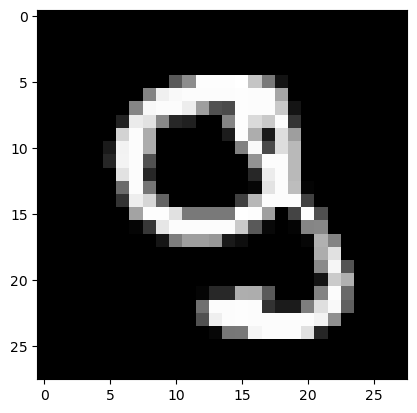

In [84]:
plt.imshow( image_tensor.squeeze(), cmap='gray' )

Maybe the model "thought" this 9 was an 8?